In [1]:
import addons
import numpy as np
import pandas as pd 
import os
import helpers
import random
import math
import matplotlib.pyplot as plt 
from matplotlib.patches import Polygon
from matplotlib.widgets import Slider
from matplotlib.animation import FuncAnimation

/home/hyc_1/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Apr 15 2024 07:21:32

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
def filter_signal(data,fs,lowcut,highcut,order=3):
    filtered_signal = {}
    for i in range(len(data)):
        filtered_signal[i] = addons.butter_bandpass_filter(data[i]-np.mean(data[i]),lowcut,highcut,fs,order)

    return filtered_signal

In [3]:
def filter_signal_2(data,fs,lowcut,highcut,order=3):
      return addons.butter_bandpass_filter(data-np.mean(data),lowcut,highcut,fs,order)

In [4]:
import math 
from scipy.fftpack import *

def hilbert_transform(signal):
    '''
    N : fft length
    M : number of elements to zero out
    U : DFT of signal
    V: IDFT of H(U) 
    '''

    N = len(signal)
    #take the forward Fourier transform
    U = fft(signal)
    M = N - N//2 - 1
    #Zero out negative frequency components
    U[N//2+1:] = [0] * M 
    #double fft energy except #DC0
    U[1:N//2] = 2 * U[1:N//2]
    #take inverse of Fourier transform
    v = ifft(U)
    return v 

In [5]:
from scipy.sparse import dok_matrix 
from scipy.fft import fft
from scipy.fft import fftfreq
from scipy import signal
from scipy.signal import butter, lfilter
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

def compute_FFT(signal_data,name_,rate,freq_sample= 0.001,freq_sample_welsh = 1000,lim_y = 7000, lim_x = 200, low_log = 10, high_log =90,fit=False,fit_freq_start = 4.0, fit_freq_end = 14.0,test_p0 = [3000,40,5],welsh_fit = 'alpha',signal_xmin=500,signal_xmax=900,min_x=1,save=True,savefig=False,name_2=None,optional_plot=None):

    plt.rcParams.update({'font.size': 22})
    analysis_interval_start = addons.analysis_dict["analysis_start"]
    analysis_interval_end = addons.analysis_dict["analysis_end"]
    FFT_Results = {}
    Welsh_Freqs = {}
    Welsh_Powers = {}
    if fit:
        Fit_FFT = {}
        Fit_Welsh = {}
        mean_freq = []
        mean_welsh = []
        amplitude_freq = []
        amplitude_welsh = []
        sigma_freq = []
        sigma_welsh = []
        def gaus(x, a, x0, sigma):
            return a*np.exp(-(x-x0)**2/(2*sigma**2))
    for i in signal_data:
        FFT_Results[i] = fft(signal_data[i][analysis_interval_start:analysis_interval_end]-np.mean(signal_data[i][analysis_interval_start:analysis_interval_end]))
        #Welsh_Freqs[i], Welsh_Powers[i]  = signal.welch(signal_data[i][analysis_interval_start:analysis_interval_end]-np.mean(signal_data[i][analysis_interval_start:analysis_interval_end]),fs=freq_sample_welsh)

    #Calcular los valores de frequencia correspondientes
    #freq = fftfreq(len(signal_data[i][analysis_interval_start:analysis_interval_end]),d=freq_sample) * 1000
    freq = fftfreq(len(signal_data[i][analysis_interval_start:analysis_interval_end]),d=freq_sample)
    if fit:
        index_start = int(np.where(freq==fit_freq_start)[0][0])
        index_end = int(np.where(freq==fit_freq_end)[0][0])
    

    plt.figure(figsize=(25, 15))
    colors = ['#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5', '#3288bd']
    pops = ["L23E","L23I","L4E","L4I","L5E","L5I","L6E","L6I"]
    # Graficar la amplitud en función de la frecuencia
    colors_filter = ['#d53e4f', '#3288bd']


    plt.subplot(2, 1, 1)
    j= 0
    if optional_plot is not None:
        for i in signal_data:
            if i == 0 or i == 2:
                plt.plot(optional_plot[i][analysis_interval_start:analysis_interval_end+700], c = colors_filter[j], label = pops[i], alpha = 0.5)
                plt.plot(signal_data[i][analysis_interval_start:analysis_interval_end+700], '--', c = colors_filter[j])
                j=j+1
        plt.xlabel('time [ms]')
        plt.ylabel('population activity [spikes]')
        plt.title('background rate  = ' +str(rate))
        plt.xlim(signal_xmin,signal_xmax)    
        plt.grid(True)
        #plt.legend(loc= 'best')
        plt.legend(loc= 'upper left')
        plt.subplot(2, 2, 3)
        j= 0


    else:
        for i in signal_data:
            plt.plot(signal_data[i][analysis_interval_start:analysis_interval_end+700], c = colors[j], label = pops[i])
            j=j+1
        plt.xlabel('time [ms]')
        plt.ylabel('population activity [spikes]')
        plt.title('background rate  = ' +str(rate))
        plt.xlim(signal_xmin,signal_xmax)    
        plt.grid(True)
        #plt.legend(loc= 'best')
        plt.legend(loc= 'upper left')
        plt.subplot(2, 2, 3)
        j= 0

    indx = int(len(signal_data[i][analysis_interval_start:analysis_interval_end])/2)
    for i in FFT_Results:
        if fit:
            try:
                Fit_FFT[i], __ = curve_fit(gaus,freq[index_start:index_end],np.abs(FFT_Results[i][index_start:index_end]),p0 = test_p0)
            except RuntimeError:
                print("Error in curve fitting for index:", i)
                Fit_FFT[i] = [0, 0, 0]
            if Fit_FFT[i][1] <= 0:
                Fit_FFT[i][1] = 0
                Fit_FFT[i][0] = 0
            if Fit_FFT[i][1] >= 15 and welsh_fit == 'alpha':
                Fit_FFT[i][1] = 0
                Fit_FFT[i][0] = 0
            mean_freq = np.append(mean_freq,Fit_FFT[i][1])
            amplitude_freq = np.append(amplitude_freq,Fit_FFT[i][0])
            sigma_freq = np.append(sigma_freq,Fit_FFT[i][2])

            plt.plot(freq[index_start:index_end],gaus(freq[index_start:index_end],*Fit_FFT[i]),'--', c = colors[j])
        plt.plot(freq[:indx], np.abs(FFT_Results[i])[:indx],c = colors[j], label = pops[i])
        j=j+1
    plt.xlabel('frequency [Hz]')
    plt.ylabel('ampltidue [spikes]')
    plt.figtext(0.5,0.48,"Fast Fourier Transform", va="center", ha="center", size=22)
    plt.grid(True)
    plt.xlim(min_x,lim_x)
    #plt.ylim(0,lim_y)
    #plt.legend(loc= 'best')

    plt.subplot(2, 2, 4)
    j= 0
    indx = int(len(signal_data[i][analysis_interval_start:analysis_interval_end])/2)
    for i in FFT_Results:
        if fit:
            plt.plot(freq[index_start:index_end],20 * np.log10(gaus(freq[index_start:index_end],*Fit_FFT[i])),'--', c = colors[j])
        plt.plot(freq[:indx], 20 * np.log10(np.abs(FFT_Results[i])[:indx]),c = colors[j], label = pops[i])
        j=j+1
    plt.xlabel('frequency [Hz]')
    plt.ylabel('amplitude [dB]')
    #plt.title('Voltage (minus the mean) FFT')
    plt.grid(True)
    plt.xlim(min_x,lim_x)
    plt.ylim(low_log,high_log)

    result_fourier = {}

    for i in FFT_Results:
        result_fourier[i] = np.abs(FFT_Results[i])[:indx]
    results_freq = freq[:indx]
    #plt.legend(loc= 'best')

    # plt.subplot(2, 3, 6)
    # j= 0

    # #plt.ylim([0.5e-3, 1])
    # for i in Welsh_Freqs:
    #     if fit:
    #         if welsh_fit == 'alpha':
    #             try:
    #                 i_start = int(np.where((Welsh_Freqs[i] < 6) & (Welsh_Freqs[i] > 0.0))[0][0])
    #             except IndexError:
    #                 i_start = 0
    #             i_end = int(np.where((Welsh_Freqs[i]<22.0) & (Welsh_Freqs[i] >18.0))[0][0])
    #             p0 = [10,10,5]

    #         if welsh_fit == 'gamma':
    #             i_start = int(np.where((Welsh_Freqs[i] <40 ) & (Welsh_Freqs[i] > 30.0))[0][0])
    #             i_end = int(np.where((Welsh_Freqs[i]<100.0) & (Welsh_Freqs[i] >90.0))[0][0])
    #             p0 = [10,40,5]
    #     if fit:
    #         if i_start - i_end <= 3:
    #             Fit_Welsh[i] = [0, 0, 0]
    #         else:
    #             Fit_Welsh[i], __ = curve_fit(gaus,Welsh_Freqs[i][i_start:i_end],Welsh_Powers[i][i_start:i_end],p0 = p0)
    #         mean_welsh = np.append(mean_welsh,Fit_Welsh[i][1])
    #         amplitude_welsh = np.append(amplitude_welsh,Fit_Welsh[i][0])
    #         sigma_welsh = np.append(sigma_welsh,Fit_Welsh[i][2])
    #         plt.plot(Welsh_Freqs[i][i_start:i_end],gaus(Welsh_Freqs[i][i_start:i_end],*Fit_Welsh[i]),'--', c = colors[j])
    #     plt.plot(Welsh_Freqs[i], Welsh_Powers[i],c = colors[j], label = pops[i])
    #     j=j+1
    # plt.xlabel('frequency [Hz]')
    # plt.ylabel(r'PSD $[V^2/Hz]$')
    # plt.title('Welsh PSD',fontsize=22)
    # plt.grid(True)
    
  
    # plt.xlim(min_x,lim_x)
    # plt.yscale('log')
    # plt.tight_layout()
    if savefig:
        if save:
            if welsh_fit == 'alpha':
                name = name_2 + '/results/fft_alpha.svg'
            elif welsh_fit == 'gamma':
                name = name_2 + '/results/fft_gamma.svg'
        else:
            name = name_2 + '/results/fft.svg'
        plt.savefig(name, dpi=300, bbox_inches='tight')
    plt.close()

    if save:
        pops = [0,1,2,3,4,5,6,7]
        #np.savetxt(name_, np.c_[pops,mean_freq, amplitude_freq, sigma_freq, mean_welsh,amplitude_welsh,sigma_welsh], fmt = '%.2f', header = 'Pops mean_freq amplitude sigma mean_welsh amplitude_welsh sigma_welsh', delimiter = ' ')
        np.savetxt(name_, np.c_[pops,mean_freq, amplitude_freq, sigma_freq], fmt = '%.2f', header = 'Pops mean_freq amplitude sigma', delimiter = ' ')

    return result_fourier, results_freq, Welsh_Freqs, Welsh_Powers, indx

In [6]:
def analyse_synchrony(num_neurons,name,bin_width=3,t_r = 2,dt=0.01):
    analysis_interval_start = addons.analysis_dict["analysis_start"]
    analysis_interval_end = addons.analysis_dict["analysis_end"]
    analysis_interval_start_s = addons.analysis_dict["synchrony_start"]
    analysis_interval_end_s = addons.analysis_dict["synchrony_end"]
    
    
    analysis_length = analysis_interval_end - analysis_interval_start
    analysis_length_s = analysis_interval_end_s - analysis_interval_start_s
    if analysis_length - analysis_length_s < 0:
        print('There is a problem. Synchrony measurement range must be smaller than the other')
        return 

    sd_names, node_ids, data = helpers.__load_spike_times(name,"spike_recorder",analysis_interval_start_s, analysis_interval_end_s)

    data_s = {}

    for i in data:
        low = np.searchsorted(data[i]["time_ms"],v=analysis_interval_start_s,side="left")
        high = np.searchsorted(data[i]["time_ms"],v=analysis_interval_end_s,side='right')
        data_s[i] = data[i][low:high]


    synchrony_pd = []
    irregularity = []
    irregularity_pdf = {}
    times_s = {}
    for i, n in enumerate(sd_names):

        #Computing synchrony
        neurons = np.unique(data_s[i]["sender"])
        random.shuffle(neurons)
        chosen_ones = neurons[1:1000]
        indices = []
        for indx in chosen_ones:
            indices = np.append(indices,np.where(data_s[i]["sender"]==indx))
        indices = np.array(indices,dtype=int)
        times_s[i] = data_s[i][indices]["time_ms"]
        counts, bins = np.histogram(times_s[i], bins=int(analysis_length_s/bin_width))
        if np.mean(counts) == 0:
            synchrony_pd = np.append(synchrony_pd,0)
        else:
            synchrony_pd = np.append(synchrony_pd,np.var(counts)/np.mean(counts))

    for i,n in enumerate(sd_names):
        single_irregularity = []
        used_senders = []
        single_lvr = 0
        lvr = []
        for senders in data[i]["sender"]:
            individual_neurons = []
            times = []
            isi = []
            count = 0
            if senders not in used_senders:
                used_senders = np.append(used_senders,senders)
                individual_neurons = np.append(individual_neurons,np.where(data[i]["sender"]==senders))
                for index in individual_neurons:
                    times = np.append(times,data[i][int(index)]["time_ms"])

                if len(times)>4:
                    for j in range(len(times)-1):
                        isi = np.append(isi,times[j+1]-times[j])
                    mean =np.mean(isi)
                    var = np.sqrt(np.var(isi))
                    single_irregularity = np.append(single_irregularity,np.float128(var/mean))
                    count = count + 1    
                if count >= 1000:
                    break

        if np.mean(single_irregularity)==None:
            irregularity = np.append(irregularity,0)
        else:
            irregularity = np.append(irregularity,np.mean(single_irregularity))
            irregularity_pdf[i] = single_irregularity
 
    return synchrony_pd, irregularity, irregularity_pdf, times_s 


In [7]:
def plot_synchrony(synchrony_pd, synchrony_chi, irregularity_pdf, name):

    a = plt.figure(figsize=(18,18))

#####################################################################################################################
    pops = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]
    colours = ['#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5', '#3288bd']
    fs = 18
    medianprops = dict(linestyle="-", linewidth=2.5, color="black")
    meanprops = dict(linestyle="--", linewidth=2.5, color="darkgray")

    plt.subplot(3, 1, 1)
    plt.barh(pops[::-1], synchrony_pd[::-1], color = colours[::-1])
    plt.xlabel('synchrony', fontsize = fs)
    plt.grid(alpha = 0.5)


###########################################################################################################################
    plt.subplot(3,1,2)
    test = []
    colours_box = ['#3288bd','#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5']
    pops_box = pops
    j = 0
    label_pos = list(range(len(pops_box),0,-1))
    for i in np.arange(len(pops)):
        if len(irregularity_pdf[i]) == 0: 
            del pops_box[i-j]
            j = j+1
        else:
            test.append(irregularity_pdf[i])
    bp = plt.boxplot(test, 0, "rs",0,medianprops=medianprops,meanprops=meanprops, meanline=True, showmeans=True,orientation='horizontal')
    label_pos = list(range(len(pops_box), 0, -1))
    if len(pops) != len(pops_box):
        colours_box = ['#3288bd', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5']
    for i in np.arange(len(pops_box)):
        boxX = []
        boxY = []
        box = bp["boxes"][i]
        for j in list(range(5)):
            boxX.append(box.get_xdata()[j])
            boxY.append(box.get_ydata()[j])
        boxCoords = list(zip(boxX, boxY))
        boxPolygon = Polygon(boxCoords, facecolor=colours_box[-i])
        plt.gca().add_patch(boxPolygon)
    plt.xlabel('irregulatiry', fontsize = fs)
    plt.yticks(label_pos, pops_box, fontsize=fs)
    plt.grid(alpha = 0.5)

############################################################################################################
    plt.subplot(3,1,3)
    pops = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]
    colours = ['#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5', '#3288bd']
    colours_pdf = list(reversed(colours))
    pops_pdf = list(reversed(pops))
    irregularity_total = []
    for i in irregularity_pdf:
        data, bins= np.histogram(irregularity_pdf[i],density=True,bins=50)
        irregularity_total = np.append(irregularity_total,irregularity_pdf[i])
        plt.plot(bins[:-1],data,alpha=0.3+i*0.1, label = pops_pdf[i], color = colours_pdf[i])

    data_t, bins_s = np.histogram(irregularity_total,density=True,bins=50)
    plt.plot(bins[:-1],data_t, label = 'Total', color = 'black', ls = 'dashed')
   
    plt.legend()
    plt.ylabel('P (irregularity)', fontsize = fs)
    plt.xlabel('CV ISI', fontsize = fs)
    plt.grid(alpha = 0.5)
    plt.xlim(0,1.8)
    plt.ylim(0,3.6)

plt.close('all')

In [8]:
#super_name = 'data_background_rate_big'
super_name = 'data_exin_big'

In [ ]:
list_dirs_2 = os.listdir(super_name )
list_dirs_2 = sorted(list_dirs_2)

for i, super_dir in enumerate(list_dirs_2):
    name_2 = super_name + "/" + str(super_dir)
    list_dirs = os.listdir(name_2)
    list_dirs = sorted(list_dirs)
    print(super_dir)
    for l, dir in enumerate(list_dirs):
        name = name_2 + '/' +  str(dir)
        test = name_2 + '/' +  str(dir) + "/" + 'results/'
        if not os.path.isdir(test):
            neuron_id = np.loadtxt((os.path.join(name,"population_nodeids.dat")),dtype=int)
            num_neurons = []
            for j in range(len(neuron_id)):
                num_neurons = np.append(num_neurons,int(neuron_id[j][1]-neuron_id[j][0]+1))
            num_neurons = num_neurons.astype(int)
            #Correctly reading the number of neurons
            name = name_2 + '/' +  str(dir) + "/"
            synchrony_pd, irregularity, irregularity_pdf, times_s = analyse_synchrony(num_neurons,name)
            name_3 = name + 'results/'

            if not os.path.isdir(name_3):
                os.mkdir(name_3)

            np.savetxt(name_3 + "synchrony.dat",synchrony_pd)
            np.savetxt(name_3 + "irregularity.dat",irregularity)
            if not os.path.isdir(name_3+"irregularities/"):
                os.mkdir(name_3+"irregularities/")
            if not os.path.isdir(name_3+"times/"):
                os.mkdir(name_3+"times/")

            for m in irregularity_pdf:
                np.savetxt(name_3 + "irregularities/irregularity_"+str(m)+".dat",irregularity_pdf[m])
            for m in times_s:
                np.savetxt(name_3 + "times/time_"+str(m)+".dat",times_s[m])

In [ ]:
list_dirs_2 = os.listdir(super_name )
list_dirs_2 = sorted(list_dirs_2)

data = {}
node_ids = {}
sd_names = {}

for i, super_dir in enumerate(list_dirs_2):
    name_2 = super_name + "/" + str(super_dir) + "/trial_7/"
    sd_names[i], node_ids[i], data[i] = helpers.__load_spike_times(name_2,"spike_recorder",500,5500)


In [ ]:
color_list = ['#d6949c', '#f5b7a4', '#fcd4ac', '#ffeebf', '#edf5c9', '#d2ded1', '#b4c2be', '#7da4bd']
ylabels = ["L2/3E", "L2/3I", "L4E", "L4I", "L5E", "L5I", "L6E","L6I"]
for i in data:
    plt.figure(figsize=(15,10))
    for j, n in enumerate(sd_names[i]):
        last_node_id = node_ids[i][-1, -1]
        mod_node_ids = np.abs(node_ids[i] - last_node_id) + 1
        label_pos = np.zeros(8)

        for n in np.arange(0,8,1):
            if n%2 == 0:
                label_pos[n] = (mod_node_ids[n, 0] + mod_node_ids[n + 1, 1]) / 2.0
        times = data[i][j]["time_ms"]
        neurons = np.abs(data[i][j]["sender"] - last_node_id) + 1
        plt.scatter(times,neurons,s=0.1,color = color_list[j])
    plt.xlabel('time [ms]')
    plt.ylabel('neuron id')
    plt.title('background rate  = ' +str(list_dirs_2[i]))
    plt.xlim(1300,1500)
    plt.yticks(label_pos, ylabels, fontsize = 15)
    plt.ylim(0,last_node_id)


In [ ]:
#Now all measurements are made for each background rate, we want to obtain the final one for each bacground rate
number_trials = 10
list_dirs_2 = os.listdir(super_name)
list_dirs_2 = sorted(list_dirs_2)

synchronies_pd = np.zeros((len(list_dirs_2),number_trials,8))
irregularities = np.zeros((len(list_dirs_2),number_trials,8))

syncrho_mean = np.zeros((len(list_dirs_2),8))
irregularity_mean = np.zeros((len(list_dirs_2),8))
syncrho_std = np.zeros((len(list_dirs_2),8))
irregularity_std = np.zeros((len(list_dirs_2),8))

for i, super_dir in enumerate(list_dirs_2):
    name_2 = super_name + "/" + str(super_dir)
    list_dirs = os.listdir(name_2)
    list_dirs = sorted(list_dirs)
    for l, dir in enumerate(list_dirs):
        if dir != 'results':
            name = name_2 + '/' +  str(dir) + "/results/"
            synchrony_pd = np.loadtxt(name + "synchrony.dat")
            synchronies_pd[i,l-1,:] =  synchrony_pd
            irregularity = np.loadtxt(name + "irregularity.dat")
            irregularities[i,l-1,:] = irregularity
    syncrho_mean[i,:] = np.nanmean(synchronies_pd[i,:,:],axis=0)
    irregularity_mean[i,:] = np.nanmean(irregularities[i,:,:],axis=0)
    syncrho_std[i,:] = np.nanstd(synchronies_pd[i,:,:],axis=0)
    irregularity_std[i,:] = np.nanstd(irregularities[i,:,:],axis=0)

    if not os.path.isdir(name_2 + "/results/"):
        os.mkdir(name_2 + "/results/")
    np.savetxt(name_2 + "/results/mean_synchronies_pd.dat", syncrho_mean[i])
    np.savetxt(name_2 + "/results/mean_irregularities.dat", irregularity_mean[i])
    np.savetxt(name_2 + "/results/std_synchronies_pd.dat", syncrho_std[i])
    np.savetxt(name_2 + "/results/std_irregularities.dat", irregularity_std[i])

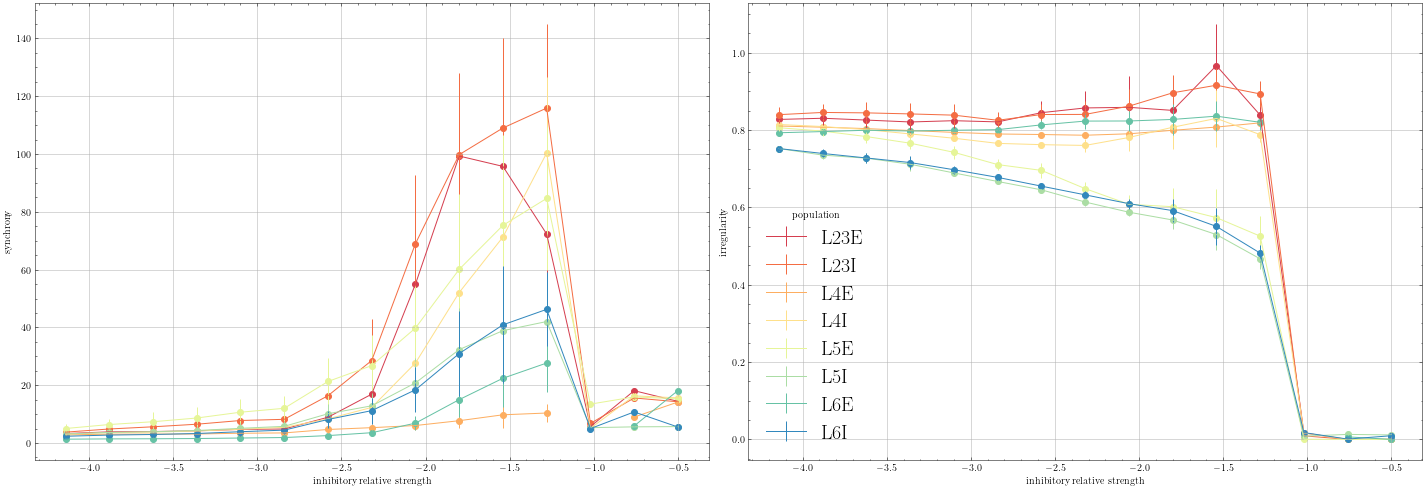

In [9]:
import matplotlib
import matplotlib.pyplot as plt 
matplotlib.rcParams.update({'font.size': 20})

names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]
colours = ['#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5', '#3288bd']

list_dirs = os.listdir(super_name   )
list_dirs = sorted(list_dirs)
synchrony = np.zeros((len(list_dirs),len(names)))
irregularity = np.zeros((len(list_dirs),len(names)))
synchrony_std = np.zeros((len(list_dirs),len(names)))
irregularity_std = np.zeros((len(list_dirs),len(names)))

xlabels = np.zeros(len(list_dirs))

for i in range(len(list_dirs)):
    synchrony[i][:] = np.loadtxt(super_name + '/'+list_dirs[i]+"/results/mean_synchronies_pd.dat")
    synchrony_std[i][:] = np.loadtxt(super_name + '/'+list_dirs[i]+"/results/std_synchronies_pd.dat")
    irregularity[i][:] = np.loadtxt(super_name + "/" + list_dirs[i]+"/results/mean_irregularities.dat")
    irregularity_std[i][:] = np.loadtxt(super_name + "/" + list_dirs[i]+"/results/std_irregularities.dat")
    xlabels[i] = float(list_dirs[i])
synchrony = np.transpose(synchrony)
irregularity = np.transpose(irregularity)
synchrony_std = np.transpose(synchrony_std)
irregularity_std = np.transpose(irregularity_std)

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)

for i in range(len(synchrony[:])):
    plt.errorbar(xlabels,synchrony[i][:],synchrony_std[i][:],label=names[i],color=colours[i])
    plt.scatter(xlabels,synchrony[i][:],color=colours[i])

plt.xlabel('inhibitory relative strength')
plt.ylabel("synchrony")
#plt.legend(fontsize=15)
plt.grid()
#plt.ylim(0.5,1.5)
#plt.title("Evolution of synchrony as a function of background rate")

plt.subplot(1,2,2)

for i in range(len(irregularity[:])):
    plt.errorbar(xlabels,irregularity[i][:],irregularity_std[i][:],label=names[i],color=colours[i])
    plt.scatter(xlabels,irregularity[i][:],color=colours[i])

plt.xlabel('inhibitory relative strength')
plt.ylabel("irregularity")
plt.legend(fontsize=20, title="population")
plt.grid()

#plt.ylim(0.5,1.5)
#plt.title("Evolution of synchrony as a function of refractory period")
plt.tight_layout()


plt.show()

Error in curve fitting for index: 2


/tmp/ipykernel_915/348643846.py:27: RuntimeWarning:divide by zero encountered in divide
/tmp/ipykernel_915/348643846.py:114: RuntimeWarning:divide by zero encountered in log10
/tmp/ipykernel_915/348643846.py:115: RuntimeWarning:divide by zero encountered in log10


Abort is in progress...hit ctrl-c again within 5 seconds to forcibly terminate



KeyboardInterrupt: 

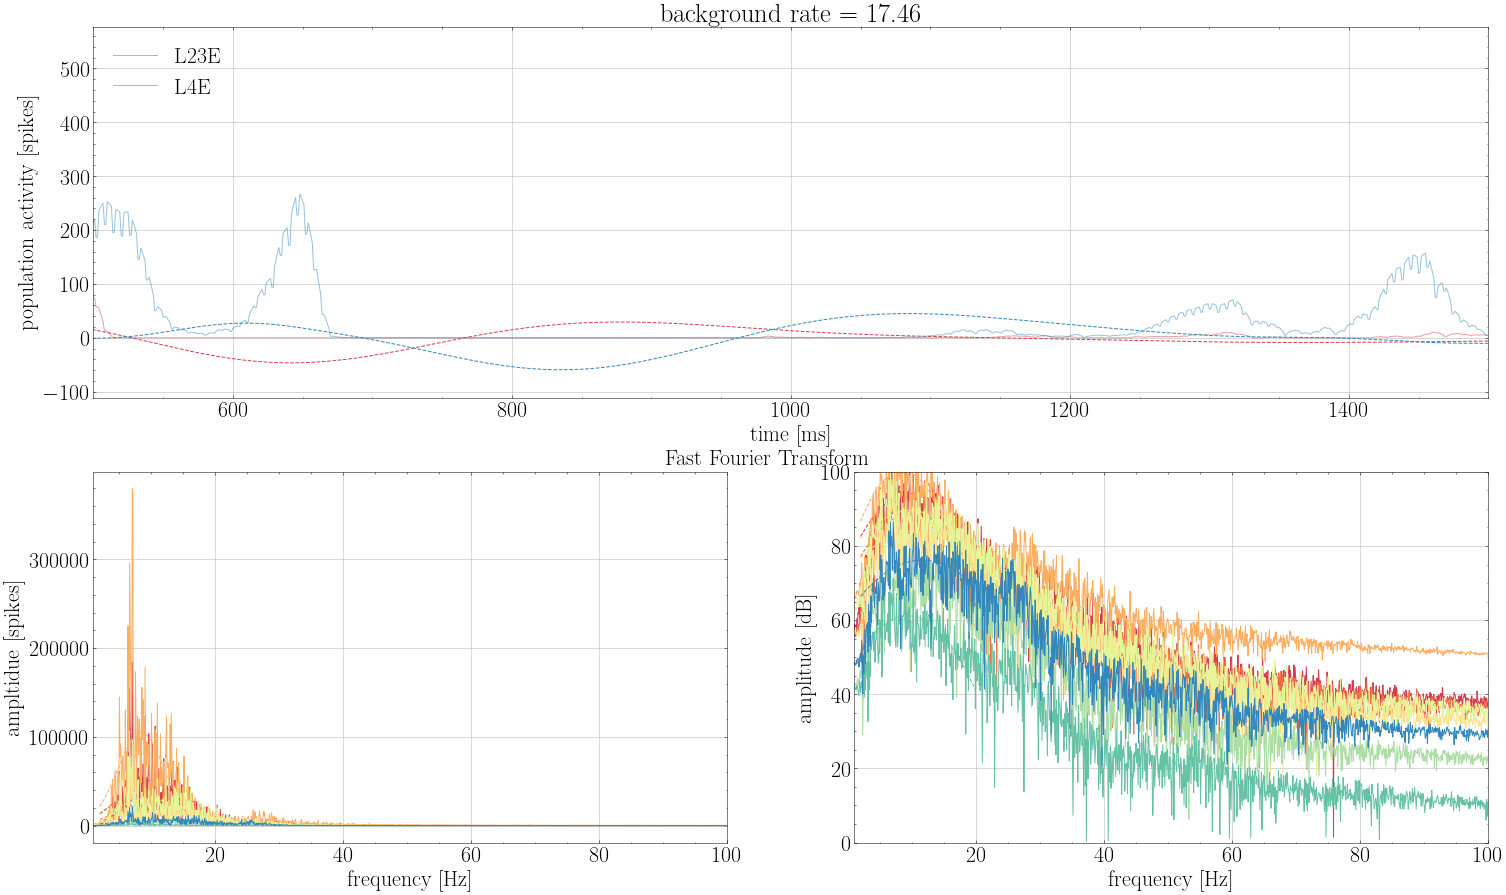

In [85]:

list_dirs = os.listdir(super_name)
list_dirs = sorted(list_dirs)


names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]


lowcut_alpha = 5
highcut_alpha =15

lowcut_gamma = 20
highcut_gamma = 40

freq_sample = 0.0002
fs_sampling = 5000
freq_sample_welsh = 5000

for i, dir in enumerate(list_dirs[45:60]): #changed due to kernel problems, it was on 49, which corresponds to 17.46, kernel brok in 9,49
    name = super_name + "/" + str(dir)
    list_dirs_2 = os.listdir(name)
    #print(dir)
    list_dirs_2.remove('results')
    list_dirs_2 = sorted(list_dirs_2)
    for j, dir_2 in enumerate(list_dirs_2):
        name_2 = name + '/' + str(dir_2)
        neuron_id = np.loadtxt((os.path.join(name_2,"population_nodeids.dat")),dtype=int)
        num_neurons = []
        for l in range(len(neuron_id)):
            num_neurons = np.append(num_neurons,int(neuron_id[l][1]-neuron_id[l][0]+1))
        num_neurons = num_neurons.astype(int)
        pop_activity = {}
        for m in range(len(num_neurons)):
            pop_activity[m]= np.loadtxt(name_2+"/measurements/pop_activities/pop_activity_"+str(m)+".dat")
        Fourier_signal, FFT_frequencies, Welsh_frequencies, Welsh_signal, FFT_index  = compute_FFT(pop_activity,name_=name_2,rate=dir,lim_y=400000,lim_x=100,high_log=130,low_log=0,freq_sample=freq_sample,freq_sample_welsh=freq_sample_welsh,signal_xmax=1500,save=False,savefig=True,name_2=name_2)


        name_alpha = name_2 +'/results/fft_alpha.dat'
        filtered_signal_alpha = filter_signal(pop_activity,lowcut=lowcut_alpha,highcut=highcut_alpha,fs=fs_sampling)
        Fourier_signal_alpha, FFT_frequencies_alpha, Welsh_frequencies, Welsh_signal, FFT_index  = compute_FFT(filtered_signal_alpha,name_=name_alpha,test_p0=[30000,5,2],rate=dir,lim_y=100000,lim_x=100,high_log=100,low_log=0,freq_sample=freq_sample,freq_sample_welsh=freq_sample_welsh,signal_xmax=1500,save=True,fit=True,savefig=True,name_2=name_2,optional_plot=pop_activity,fit_freq_start=2,fit_freq_end=20)

        name_gamma = name_2 +'/results/fft_gamma.dat'
        filtered_signal_gamma = filter_signal(pop_activity,lowcut=lowcut_gamma,highcut=highcut_gamma,fs=fs_sampling)
        Fourier_signal_gamma, FFT_frequencies_gamma, Welsh_frequencies, Welsh_signal, FFT_index  = compute_FFT(filtered_signal_gamma,name_=name_gamma,rate=dir,test_p0=[10000,30,10],lim_y=200000,lim_x=100,high_log=120,low_log=0,freq_sample=freq_sample,freq_sample_welsh=freq_sample_welsh,signal_xmax=1500,save=True,fit=True,welsh_fit='gamma',fit_freq_start=20,fit_freq_end=60,min_x=10,savefig=True,name_2=name_2,optional_plot=pop_activity)

In [10]:

list_dirs = os.listdir(super_name)
list_dirs = sorted(list_dirs)

names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]
num_trials = 10
freq_sample = 0.0002
fs_sampling = 5000
freq_sample_welsh = 5000

Fourier_data = np.zeros((len(list_dirs),num_trials,8,30000))
Fourier_data_final = np.zeros((len(list_dirs),8,30000))

for i, dir in enumerate(list_dirs): #changed due to kernel problems, it was on 49, which corresponds to 17.46, kernel brok in 9,49
    name = super_name + "/" + str(dir)
    list_dirs_2 = os.listdir(name)
    #print(dir)
    list_dirs_2.remove('results')
    list_dirs_2 = sorted(list_dirs_2)
    for j, dir_2 in enumerate(list_dirs_2):
        name_2 = name + '/' + str(dir_2)
        neuron_id = np.loadtxt((os.path.join(name_2,"population_nodeids.dat")),dtype=int)
        num_neurons = []
        for l in range(len(neuron_id)):
            num_neurons = np.append(num_neurons,int(neuron_id[l][1]-neuron_id[l][0]+1))
        num_neurons = num_neurons.astype(int)
        pop_activity = {}
        for m in range(len(num_neurons)):
            pop_activity[m]= np.loadtxt(name_2+"/measurements/pop_activities/pop_activity_"+str(m)+".dat")
        Fourier_data_help, FFT_frequencies, Welsh_frequencies, Welsh_signal, FFT_index  = compute_FFT(pop_activity,name_=name_2,rate=dir,lim_y=400000,lim_x=100,high_log=130,low_log=0,freq_sample=freq_sample,freq_sample_welsh=freq_sample_welsh,signal_xmax=1500,save=False,savefig=True,name_2=name_2)
        for m in range(len(num_neurons)):
            Fourier_data[i,j,m,:] = (Fourier_data_help[m])
    Fourier_data_final[i,:,:] = np.mean(Fourier_data[i,:,:,:],axis=0)

/tmp/ipykernel_810413/348643846.py:115: RuntimeWarning:divide by zero encountered in log10
/tmp/ipykernel_810413/348643846.py:115: RuntimeWarning:divide by zero encountered in log10


In [11]:

list_dirs = os.listdir(super_name)
list_dirs = sorted(list_dirs)


names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]


lowcut_alpha = 5
highcut_alpha =15

freq_sample = 0.0002
fs_sampling = 5000
freq_sample_welsh = 5000


Fourier_data_alpha = np.zeros((len(list_dirs),num_trials,8,30000))
Fourier_data_alpha_final = np.zeros((len(list_dirs),8,30000))

for i, dir in enumerate(list_dirs): #changed due to kernel problems, it was on 49, which corresponds to 17.46, kernel brok in 9,49
    name = super_name + "/" + str(dir)
    list_dirs_2 = os.listdir(name)
    #print(dir)
    list_dirs_2.remove('results')
    list_dirs_2 = sorted(list_dirs_2)
    for j, dir_2 in enumerate(list_dirs_2):
        name_2 = name + '/' + str(dir_2)
        neuron_id = np.loadtxt((os.path.join(name_2,"population_nodeids.dat")),dtype=int)
        num_neurons = []
        for l in range(len(neuron_id)):
            num_neurons = np.append(num_neurons,int(neuron_id[l][1]-neuron_id[l][0]+1))
        num_neurons = num_neurons.astype(int)
        pop_activity = {}
        for m in range(len(num_neurons)):
            pop_activity[m]= np.loadtxt(name_2+"/measurements/pop_activities/pop_activity_"+str(m)+".dat")

        name_alpha = name_2 +'/results/fft_alpha.dat'
        filtered_signal_alpha = filter_signal(pop_activity,lowcut=lowcut_alpha,highcut=highcut_alpha,fs=fs_sampling)
        Fourier_signal_alpha, FFT_frequencies_alpha, Welsh_frequencies, Welsh_signal, FFT_index  = compute_FFT(filtered_signal_alpha,name_=name_alpha,test_p0=[30000,5,2],rate=dir,lim_y=100000,lim_x=100,high_log=100,low_log=0,freq_sample=freq_sample,freq_sample_welsh=freq_sample_welsh,signal_xmax=1500,save=True,fit=True,savefig=True,name_2=name_2,optional_plot=pop_activity,fit_freq_start=2,fit_freq_end=20)
        for m in range(len(num_neurons)):
            Fourier_data_alpha[i,j,m,:] = (Fourier_signal_alpha[m])
    Fourier_data_alpha_final[i,:,:] = np.mean(Fourier_data_alpha[i,:,:,:],axis=0)

/tmp/ipykernel_810413/348643846.py:115: RuntimeWarning:divide by zero encountered in log10
/tmp/ipykernel_810413/348643846.py:114: RuntimeWarning:divide by zero encountered in log10


In [12]:

list_dirs = os.listdir(super_name)
list_dirs = sorted(list_dirs)


names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]



lowcut_gamma = 20
highcut_gamma = 40

freq_sample = 0.0002
fs_sampling = 5000
freq_sample_welsh = 5000

Fourier_data_gamma = np.zeros((len(list_dirs),num_trials,8,30000))
Fourier_data_gamma_final = np.zeros((len(list_dirs),8,30000))

for i, dir in enumerate(list_dirs): #changed due to kernel problems, it was on 49, which corresponds to 17.46, kernel brok in 9,49
    name = super_name + "/" + str(dir)
    list_dirs_2 = os.listdir(name)
    #print(dir)
    list_dirs_2.remove('results')
    list_dirs_2 = sorted(list_dirs_2)
    for j, dir_2 in enumerate(list_dirs_2):
        name_2 = name + '/' + str(dir_2)
        neuron_id = np.loadtxt((os.path.join(name_2,"population_nodeids.dat")),dtype=int)
        num_neurons = []
        for l in range(len(neuron_id)):
            num_neurons = np.append(num_neurons,int(neuron_id[l][1]-neuron_id[l][0]+1))
        num_neurons = num_neurons.astype(int)
        pop_activity = {}
        for m in range(len(num_neurons)):
            pop_activity[m]= np.loadtxt(name_2+"/measurements/pop_activities/pop_activity_"+str(m)+".dat")

        name_gamma = name_2 +'/results/fft_gamma.dat'
        filtered_signal_gamma = filter_signal(pop_activity,lowcut=lowcut_gamma,highcut=highcut_gamma,fs=fs_sampling)
        Fourier_signal_gamma, FFT_frequencies_gamma, Welsh_frequencies, Welsh_signal, FFT_index  = compute_FFT(filtered_signal_gamma,name_=name_gamma,rate=dir,test_p0=[10000,30,10],lim_y=200000,lim_x=100,high_log=120,low_log=0,freq_sample=freq_sample,freq_sample_welsh=freq_sample_welsh,signal_xmax=1500,save=True,fit=True,welsh_fit='gamma',fit_freq_start=20,fit_freq_end=60,min_x=10,savefig=True,name_2=name_2,optional_plot=pop_activity)
        for m in range(len(num_neurons)):
            Fourier_data_gamma[i,j,m,:] = (Fourier_signal_gamma[m])
    Fourier_data_gamma_final[i,:,:] = np.mean(Fourier_data_gamma[i,:,:,:],axis=0)

/tmp/ipykernel_810413/348643846.py:114: RuntimeWarning:invalid value encountered in log10
/tmp/ipykernel_810413/348643846.py:115: RuntimeWarning:divide by zero encountered in log10
/tmp/ipykernel_810413/348643846.py:114: RuntimeWarning:invalid value encountered in log10
/tmp/ipykernel_810413/348643846.py:115: RuntimeWarning:divide by zero encountered in log10
/tmp/ipykernel_810413/348643846.py:114: RuntimeWarning:invalid value encountered in log10
/tmp/ipykernel_810413/348643846.py:115: RuntimeWarning:divide by zero encountered in log10
/tmp/ipykernel_810413/348643846.py:115: RuntimeWarning:divide by zero encountered in log10


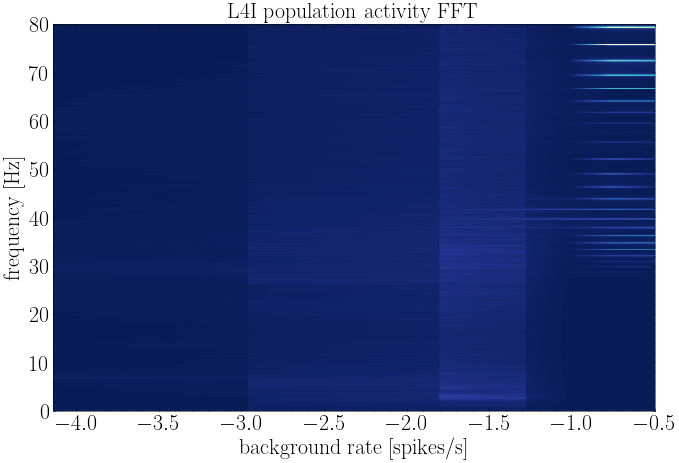

In [17]:
bg_rates = np.linspace(0.5,20,len(list_dirs))
bg_rates = [-0.5,-0.76,-1.02,-1.8,-1.28,-1.54,-2.96,-2.32,-2.58,-2.84,-3.1,-3.36,-3.62,-3.88,-4.14]
plt.figure(figsize=(10,7))
fs = 22
plt.contourf(bg_rates,FFT_frequencies,np.transpose(Fourier_data_final[:,3,:]), levels=300, cmap='YlGnBu_r')
plt.ylim(top=80)
plt.xlabel('background rate [spikes/s]', fontsize=fs)
plt.ylabel('frequency [Hz]', fontsize=fs)
plt.title('L4I population activity FFT', fontsize=fs)
plt.tight_layout()

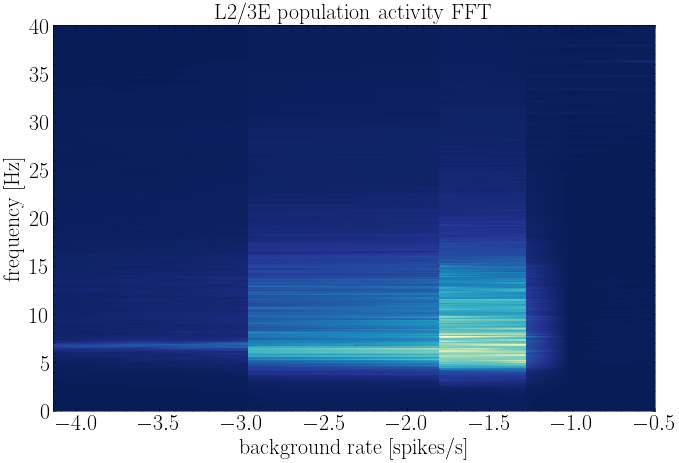

In [21]:
bg_rates = np.linspace(0.5,20,len(list_dirs))
bg_rates = [-0.5,-0.76,-1.02,-1.8,-1.28,-1.54,-2.96,-2.32,-2.58,-2.84,-3.1,-3.36,-3.62,-3.88,-4.14]
plt.figure(figsize=(10,7))
fs = 22
plt.contourf(bg_rates,FFT_frequencies,np.transpose(Fourier_data_alpha_final[:,5,:]), levels=1000, cmap='YlGnBu_r')
plt.ylim(top=40)
plt.xlabel('background rate [spikes/s]', fontsize=fs)
plt.ylabel('frequency [Hz]', fontsize=fs)
plt.title('L2/3E population activity FFT', fontsize=fs)
plt.tight_layout()

Locator attempting to generate 1001 ticks ([0.0, ..., 60000.0]), which exceeds Locator.MAXTICKS (1000).


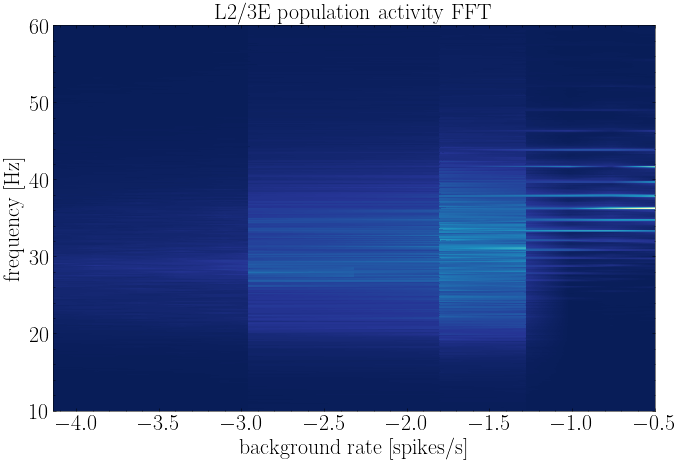

In [22]:
bg_rates = np.linspace(0.5,20,len(list_dirs))
bg_rates = [-0.5,-0.76,-1.02,-1.8,-1.28,-1.54,-2.96,-2.32,-2.58,-2.84,-3.1,-3.36,-3.62,-3.88,-4.14]
plt.figure(figsize=(10,7))
fs = 22
plt.contourf(bg_rates,FFT_frequencies,np.transpose(Fourier_data_gamma_final[:,5,:]), levels=1000, cmap='YlGnBu_r')
plt.ylim(top=60)
plt.ylim(bottom=10)
plt.xlabel('background rate [spikes/s]', fontsize=fs)
plt.ylabel('frequency [Hz]', fontsize=fs)
plt.title('L2/3E population activity FFT', fontsize=fs)
plt.tight_layout()

/tmp/ipykernel_810413/353864027.py:56: RuntimeWarning:Mean of empty slice
/tmp/ipykernel_810413/353864027.py:61: RuntimeWarning:Mean of empty slice


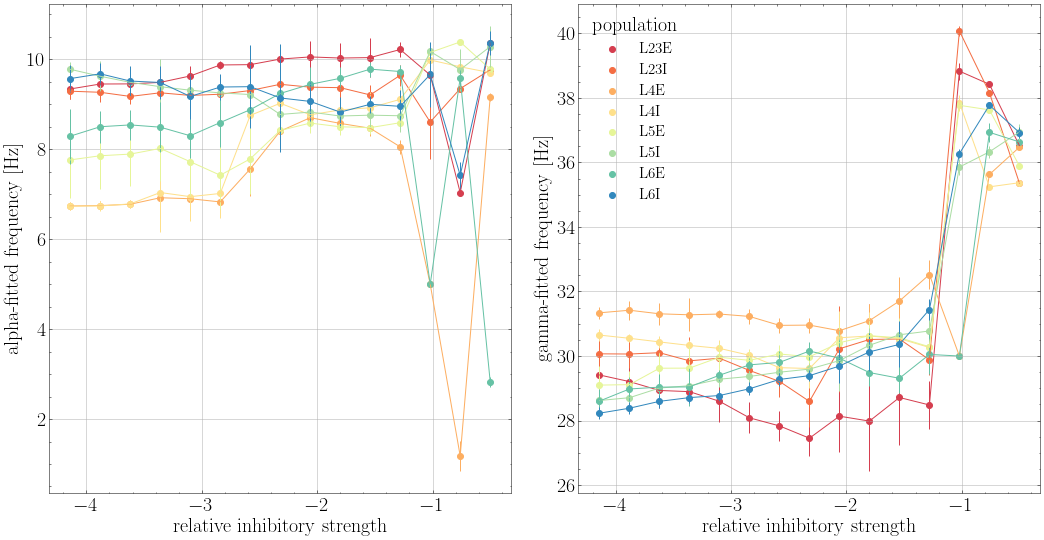

In [24]:
import matplotlib
import matplotlib.pyplot as plt 
matplotlib.rcParams.update({'font.size': 20})


names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]
colours = ['#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5', '#3288bd']
num_trials = 10

list_dirs = os.listdir(super_name)
list_dirs = sorted(list_dirs)
#We are looking at 5.0...


#These are the final arrays I want to plot
means_gamma = np.zeros((len(list_dirs),len(names)))
means_alpha = np.zeros((len(list_dirs),len(names)))
std_gamma = np.zeros((len(list_dirs),len(names)))
std_alpha = np.zeros((len(list_dirs),len(names)))
amplitude_gamma = np.zeros((len(list_dirs),len(names)))
amplitude_alpha = np.zeros((len(list_dirs),len(names)))
sdt_gamma_amplitude = np.zeros((len(list_dirs),len(names)))
sdt_alpha_amplitude = np.zeros((len(list_dirs),len(names)))


#there are the aid arrays with data
mean_gamma_aid = np.zeros((len(list_dirs),num_trials,len(names)))
mean_alpha_aid = np.zeros((len(list_dirs),num_trials,len(names)))
amplitude_gamma_aid = np.zeros((len(list_dirs),num_trials,len(names)))
amplitude_alpha_aid = np.zeros((len(list_dirs),num_trials,len(names)))
xlabels = np.zeros(len(list_dirs))

for i in range(len(list_dirs)):
    for j in range(num_trials):
        aid_gamma = np.loadtxt(super_name + "/"+list_dirs[i]+'/trial_' + str(j) +"/results/fft_gamma.dat")
        aid_gamma = aid_gamma.transpose()
        for k in range(len(aid_gamma[1])):
            if aid_gamma[1][k] <= 0:
                aid_gamma[1][k] = np.nan
            if aid_gamma[2][k] <= 0:    
                aid_gamma[2][k] = np.nan
        mean_gamma_aid[i][j][:] = aid_gamma[1]
        amplitude_gamma_aid[i][j][:] = aid_gamma[2]

        aid_alpha = np.loadtxt(super_name + "/"+list_dirs[i]+'/trial_' + str(j) +"/results/fft_alpha.dat")
        aid_alpha = aid_alpha.transpose()
        for k in range(len(aid_alpha[1])):
            if aid_alpha[1][k] <= 0:
                aid_alpha[1][k] = np.nan
            if aid_alpha[2][k] <= 0:    
                aid_alpha[2][k] = np.nan
        mean_alpha_aid[i][j][:] = aid_alpha[1]
        amplitude_alpha_aid[i][j][:] = aid_alpha[2]
    
    means_alpha[i][:] = np.nanmean(mean_alpha_aid[i],axis=0)
    amplitude_alpha[i][:] = np.nanmean(amplitude_alpha_aid[i],axis=0)
    sdt_gamma_amplitude[i][:] = np.nanstd(amplitude_gamma_aid[i],axis=0)
    sdt_alpha_amplitude[i][:] = np.nanstd(amplitude_alpha_aid[i],axis=0)
    std_alpha[i][:] = np.nanstd(mean_alpha_aid[i],axis=0)
    means_gamma[i][:] = np.nanmean(mean_gamma_aid[i],axis=0)
    amplitude_gamma[i][:] = np.nanmean(amplitude_gamma_aid[i],axis=0)
    std_gamma[i][:] = np.nanstd(mean_gamma_aid[i],axis=0)

    xlabels[i] = float(list_dirs[i])
    

means_gamma = means_gamma.transpose()
amplitude_gamma = amplitude_gamma.transpose()
std_gamma = std_gamma.transpose()
sdt_gamma_amplitude = sdt_gamma_amplitude.transpose()
sdt_alpha_amplitude = sdt_alpha_amplitude.transpose()

means_alpha = means_alpha.transpose()
amplitude_alpha = amplitude_alpha.transpose()
std_alpha = std_alpha.transpose()

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)

for i in range(len(means_alpha[:])):
    plt.scatter(xlabels,means_alpha[i][:],label=names[i],color=colours[i])
    plt.errorbar(xlabels,means_alpha[i][:],std_alpha[i][:],color=colours[i])

plt.xlabel('relative inhibitory strength')
#plt.xlabel('background rate [spikes/s]')
plt.ylabel("alpha-fitted frequency [Hz]")
#plt.legend(fontsize=15)
plt.grid()
#plt.ylim(0.5,1.5)
#plt.title("Evolution of synchrony as a function of background rate")

plt.subplot(1,2,2)

for i in range(len(means_gamma[:])):
    plt.scatter(xlabels,means_gamma[i],label=names[i],color=colours[i])
    plt.errorbar(xlabels,means_gamma[i],std_gamma[i][:],color=colours[i])

plt.xlabel('relative inhibitory strength')
#plt.xlabel('background rate [spikes/s]')
plt.ylabel("gamma-fitted frequency [Hz]")
#plt.legend(fontsize=15)
plt.grid()
plt.legend(fontsize=15, title = 'population')
plt.tight_layout()
plt.show()

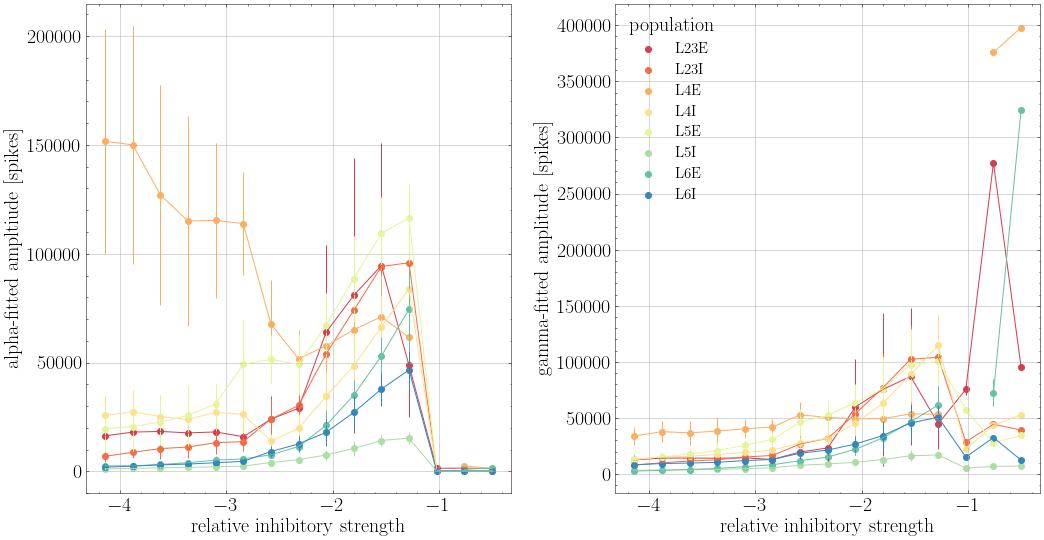

In [25]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)

for i in range(len(amplitude_alpha[:])):
    plt.scatter(xlabels,amplitude_alpha[i][:],label=names[i],color=colours[i])
    plt.errorbar(xlabels,amplitude_alpha[i][:],sdt_alpha_amplitude[i][:],color=colours[i])

plt.xlabel('relative inhibitory strength')
#plt.xlabel('background rate [spikes/s]')
plt.ylabel("alpha-fitted ampltiude [spikes]")
#plt.legend(fontsize=15)
plt.grid()
#plt.ylim(0.5,1.5)
#plt.title("Evolution of synchrony as a function of background rate")

plt.subplot(1,2,2)

for i in range(len(amplitude_gamma[:])):
    plt.scatter(xlabels,amplitude_gamma[i],label=names[i],color=colours[i])
    plt.errorbar(xlabels,amplitude_gamma[i],sdt_gamma_amplitude[i][:],color=colours[i])

plt.xlabel('relative inhibitory strength')
#plt.xlabel('background rate [spikes/s]')
plt.ylabel("gamma-fitted amplitude [spikes]")
#plt.legend(fontsize=15)
plt.grid()
plt.legend(fontsize=15, title = 'population')
plt.tight_layout()
plt.show()

In [26]:

list_dirs = os.listdir(super_name)
list_dirs = sorted(list_dirs)


names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]

pop_activity_csd = {}

for i, dir in enumerate(list_dirs): #changed due to kernel problems, it was on 49, which corresponds to 17.46, kernel brok in 9,49
    name = super_name + "/" + str(dir) + '/trial_2/'
    neuron_id = np.loadtxt((os.path.join(name,"population_nodeids.dat")),dtype=int)
    num_neurons = []
    for l in range(len(neuron_id)):
        num_neurons = np.append(num_neurons,int(neuron_id[l][1]-neuron_id[l][0]+1))
    num_neurons = num_neurons.astype(int)
    pop_activity_csd[i] = {}
    for m in range(len(num_neurons)):
        pop_activity_csd[i][m]= np.loadtxt(name+"/measurements/pop_activities/pop_activity_"+str(m)+".dat")

In [27]:
import scipy as sp

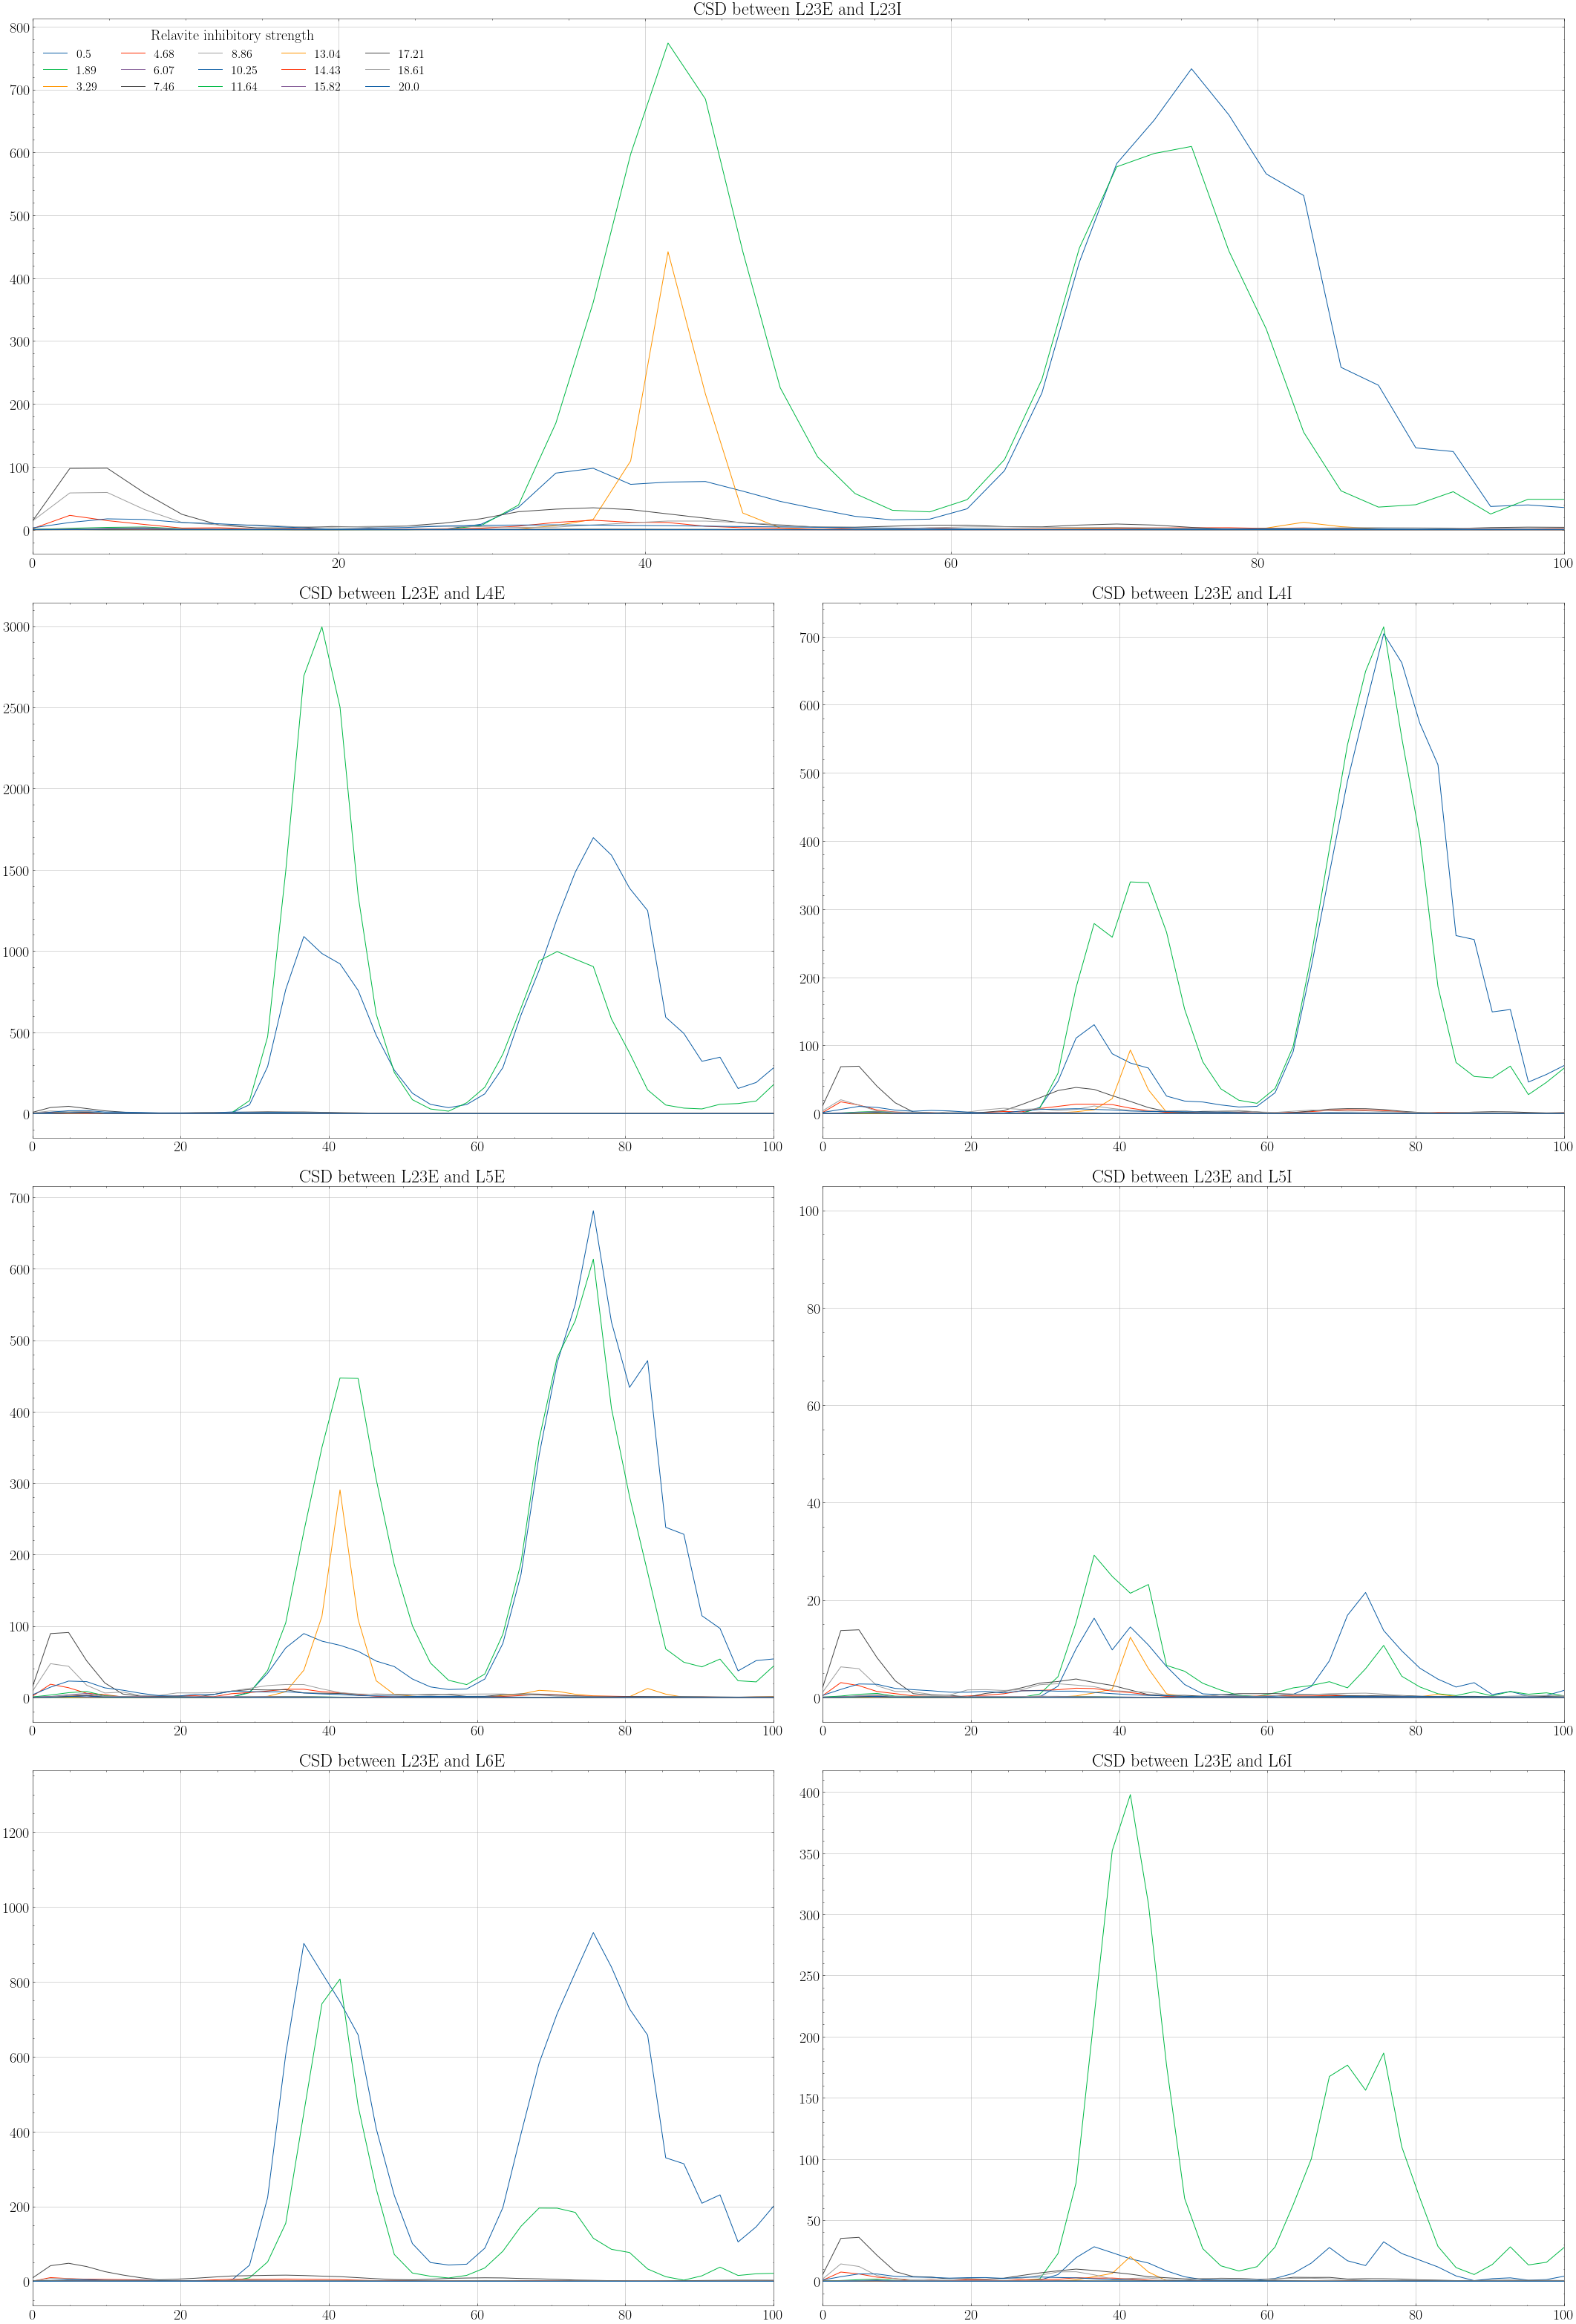

In [29]:
layer_of_interest_og = 0
nfft = 256
nfft = 2048
dt = 0.001
Fs = 5000

names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]

#labels = (-0.5,-0.76,-1.02,-1.8,-1.28,-1.54,-2.06,-2.32,-2.58,-2.84,-3.1,-3.36,-3.62,-3.88,-4.14)
labels = np.linspace(0.5,20,len(list_dirs))

saved_data_1 = {}
saved_data_2 = {}

for i in pop_activity_csd:
    saved_data_1[i] = pop_activity_csd[i][layer_of_interest_og]

plt.figure(figsize=(30,44))

for j in range(8):
    layer_of_interest_2 = j
    if layer_of_interest_2 != layer_of_interest_og:
        if j == 1:
            plt.subplot(4,1,1)
        else:
            plt.subplot(4,2,j+1)
        for i in pop_activity_csd:
            saved_data_2[i] = pop_activity_csd[i][layer_of_interest_2]
        #csdxy, fsc = plt.csd(saved_data_1[i],saved_data_2[i],NFFT=nfft,Fs=Fs,label=str(round(labels[i],2)),scale_by_freq=False)
            f, Pxy = sp.signal.csd(saved_data_1[i], saved_data_2[i], fs=Fs, nperseg=nfft)
            plt.plot(f, np.abs(Pxy), label=str(round(labels[i],2)))
            plt.xlim(0,100)
            plt.grid(True)
    if j != 0:
        plt.title("CSD between L23E and " +names[j])

    if j == 1:
        plt.legend(title= 'Relavite inhibitory strength', ncols= 5, fontsize=15, prop = {'size':16})
        #plt.legend(title= 'background rate [spikes/s]', ncols= 5, fontsize=15, prop = {'size':16})

#plt.suptitle('Cross spectral density between L23E and the other populations')

plt.tight_layout()

In [ ]:
def ComputeBISBIC(S1,S2,FFT_frequencies,Freqs1,Freqs2):
    BIS = np.zeros((len(Freqs1),len(Freqs2)))
    BIC = np.zeros((len(Freqs1),len(Freqs2)))
    for i, f1 in enumerate(Freqs1):
        try:
            ind1 = np.where(FFT_frequencies == f1)[0][0]
        except:
            helper = FFT_frequencies[min(range(len(FFT_frequencies)), key = lambda i: abs(FFT_frequencies[i]-f1))]
            ind1 = np.where(FFT_frequencies == helper)[0][0]

        for j, f2 in enumerate(Freqs2):
            try:
                ind2 = np.where(FFT_frequencies == f2)[0][0]
            except:
                helper = FFT_frequencies[min(range(len(FFT_frequencies)), key = lambda i: abs(FFT_frequencies[i]-f2))]
                ind2 = np.where(FFT_frequencies == helper)[0][0]
            try:
                ind3 = np.where(FFT_frequencies == f1 + f2)[0][0]
            except:
                helper = FFT_frequencies[min(range(len(FFT_frequencies)), key = lambda i: abs(FFT_frequencies[i]-(f2+f1)))]
                ind3 = np.where(FFT_frequencies == helper)[0][0]
            BIS[i,j] = np.abs(np.mean(S1[ind1]*S2[ind2]*np.conj(S2[ind3])))
            BIC[i,j] = BIS[i,j] / ( np.sqrt( np.mean( np.abs(S1[ind1] * S2[ind2])**2 * np.abs(S2[ind3])**2 )   ) )
    return BIS, BIC

In [ ]:
freqs_alpha = np.linspace(8,12,100)
freqs_gamma_low = np.linspace(30,48,100)
freqs_gamma_high = np.linspace(52,80,100)

layer_of_interest_1 = 0
layer_of_interest_2 = 6

BIS = {}
BIC = {}

for i, n in enumerate(Fourier_signal_alpha):

    BIS[i], BIC[i] = ComputeBISBIC(Fourier_signal_alpha[n][layer_of_interest_1],Fourier_signal_alpha[n][layer_of_interest_2],FFT_frequencies_alpha,freqs_alpha,freqs_gamma_low)

In [ ]:
for i in range(len(BIS)):

    plt.figure(figsize=(18,8))
    plt.subplot(1,2,1)

    plt.contourf(freqs_alpha,freqs_alpha,BIS[i])
    plt.xlabel('frequency (Hz)')
    plt.ylabel('frequency (Hz)')
    plt.colorbar()
    plt.title('BIS, background_rate = ' + str(i))

    plt.subplot(1,2,2)

    plt.contourf(freqs_alpha,freqs_alpha,BIC[i])
    plt.xlabel('frequency (Hz)')
    plt.ylabel('frequency (Hz)')
    plt.colorbar()
    plt.title('BIC, background_rate = ' + str(i))

In [ ]:
base_layer = 0

CFC_s = {}
frequencies_base = {}
frequencies_2 = {}

signal_hilbert = {}

filter_low = 0
filter_high = 88

for i, n in enumerate(pop_activity):
    CFC_s[i] = {}
    frequencies_base[i] = {}
    frequencies_2[i] = {}
    for j, m in enumerate(pop_activity[n]):
        signal_hilbert[base_layer] = hilbert_transform(pop_activity[n][base_layer])
        if j != base_layer:
            signal_hilbert[j] = hilbert_transform(pop_activity[n][j])
            help = np.fft.fft(signal_hilbert[base_layer])
            W = np.fft.fftfreq(len(signal_hilbert[base_layer]),d=0.001)
            help[(np.abs(W)<filter_low) &  (np.abs(W)>filter_high) ] = 0

            signal_base = np.fft.ifft(help)

            help = np.fft.fft(signal_hilbert[j])
            W = np.fft.fftfreq(len(signal_hilbert[j]),d=0.001)
            help[(np.abs(W)<filter_low) &  (np.abs(W)>filter_high) ] = 0

            signal_2 = np.fft.ifft(help)

            z = signal_base * np.conjugate(signal_2) / (np.abs(signal_base) * np.abs(signal_2))
            welsh_power = np.abs(np.fft.fft(z-np.mean(z)))
            welsh_frequencies = np.fft.fftfreq(len(z),d=0.001)

            maximum = np.max(welsh_power)
            padding = 1
            distance = np.abs(welsh_frequencies[0] - welsh_frequencies[1])

            point = np.argwhere(welsh_power==maximum)[0][0] 

            central_freq = welsh_frequencies[point]
            start = point-int(padding/distance)

            stop = point+int(padding/distance)
            if stop > len(welsh_frequencies):
                stop = len(welsh_frequencies) -1

            num = int((-start +stop)/distance)
            base_point_list = np.linspace(start,stop,num)
            base_point_list = base_point_list.astype(int)

            if central_freq + padding > 0 and central_freq < 0:
                support_freqs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
                base_point_list = np.append(base_point_list,support_freqs)
                freqs_plots = welsh_frequencies[base_point_list]
                power_plot = welsh_power[base_point_list]
            elif central_freq - padding < 0  and central_freq >0 :
                help = np.argwhere(welsh_frequencies<0)[0][0]
                support_freqs = [help,help+1,help+2,help+3,help+4,help+5,help+6,help+7,help+8,help+9,help+10,help+11,help+12,help+13,help+14,help+15,help+16,help+17,help+18,help+19]
                base_point_list = np.append(base_point_list,support_freqs)
                freqs_plots = welsh_frequencies[base_point_list]
                power_plot = welsh_power[base_point_list]
            else:
                freqs_plots = welsh_frequencies[base_point_list]
                power_plot = welsh_power[base_point_list]


            int_num = np.trapz(power_plot,x=freqs_plots)
            int_dem = np.trapz(welsh_power,x=welsh_frequencies)
            CFC_s[i][j] = int_num / int_dem

            frequencies = np.linspace(0,88,num=100)
            sigma = 1
            for l in frequencies:
                lowcut = l - sigma
                highcut = l + sigma
                help = np.fft.fft(signal_base)
                W = np.fft.fftfreq(len(signal_base),d=0.001)
                help[(np.abs(W)<highcut) &  (np.abs(W)>lowcut) ] = 0

                filtered_signal = np.fft.ifft(help)


                test_z = filtered_signal * np.conjugate(signal_2) / (np.abs(filtered_signal) * np.abs(signal_2))

                welsh_power = np.abs(np.fft.fft(test_z-np.mean(test_z)))
                welsh_frequencies = np.fft.fftfreq(len(test_z),d=0.001)

                maximum_new = np.max(welsh_power)
                point = np.argwhere(welsh_power==maximum_new)[0][0] 
                central_freq_new = welsh_frequencies[point]
                if maximum_new < maximum/1.2:
                    frequencies_base[i][j] = l 
                    break 

            for l in frequencies:
                lowcut = l - sigma
                highcut = l + sigma
                help = np.fft.fft(signal_2)
                W = np.fft.fftfreq(len(signal_2),d=0.001)
                help[(np.abs(W)<highcut) &  (np.abs(W)>lowcut) ] = 0

                filtered_signal = np.fft.ifft(help)


                test_z = signal_base * np.conjugate(filtered_signal) / (np.abs(filtered_signal) * np.abs(signal_base))

                welsh_power = np.abs(np.fft.fft(test_z-np.mean(test_z)))
                welsh_frequencies = np.fft.fftfreq(len(test_z),d=0.001)

                maximum_new = np.max(welsh_power)
                point = np.argwhere(welsh_power==maximum_new)[0][0] 
                central_freq_new = welsh_frequencies[point]
                if maximum_new < maximum/1.3:
                    frequencies_2[i][j] = l 
                    break 
            

In [ ]:
populations = ['L23I', 'L4E', 'L4I', 'L5E', 'L5I', 'L6E', 'L6I']

CFC = np.zeros((len(CFC_s),len(CFC_s[0])))
for i in range(len(CFC_s)):
    CFC[i] = np.fromiter(CFC_s[i].values(),dtype=float)
bg_rate = np.linspace(4,12,int((12-4)/0.25))

In [ ]:
plt.figure(figsize=(16,7))
y_pos = 1.0


for i in range(len(CFC_s)):
    plt.plot(populations,CFC[i], label = round(bg_rate[i],2) )

plt.legend(ncols = 4,bbox_to_anchor=(1.0,1.0),title='Background rates')
plt.ylim(0,0.07)
plt.grid()
plt.ylabel('CFC-PLM')

In [ ]:
frequencies_base[10]

In [ ]:
frequencies_2[10]

In [ ]:
len(means_gamma.transpose())

In [ ]:

index =16 

means_gamma  = means_gamma.transpose()
means_alpha = means_alpha.transpose()


#periods_gamma = 1 / means_gamma[16] * 1000
#periods_alpha = 1 / means_alpha[16] * 1000

periods_gamma = 1 / means_gamma[16] * 1000
periods_alpha = 1 / means_alpha[16] * 1000

mean_period_gamma = np.mean(periods_gamma)
mean_period_alpha = np.mean(periods_alpha)

raster_plot_interval = np.array([500, 500 + 3* mean_period_alpha])

In [ ]:
def plot_raster(path, name, begin, end, N_scaling,binned,M, std,period_alpha,period_gamma,period_volt):
    """Creates a spike raster plot of the network activity.

    Parameters
    -----------
    path
        Path where the spike times are stored.
    name
        Name of the spike recorder.
    begin
        Time point (in ms) to start plotting spikes (included).
    end
        Time point (in ms) to stop plotting spikes (included).
    N_scaling
        Scaling factor for number of neurons.

    Returns
    -------
    None

    """
    from scipy import signal
    fs = 18  # fontsize
    ylabels = ["L2/3E", "L2/3I", "L4E", "L4I", "L5E", "L5I", "L6E","L6I"]
    color_list = ['#d6949c', '#f5b7a4', '#fcd4ac', '#ffeebf', '#edf5c9', '#d2ded1', '#b4c2be', '#7da4bd']
    bar_labels =  ['#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5', '#3288bd']
    
    sd_names, node_ids, data = helpers.__load_spike_times(path, name, begin, end)
    last_node_id = node_ids[-1, -1]
    mod_node_ids = np.abs(node_ids - last_node_id) + 1
    label_pos = np.zeros(8)

    for i in np.arange(0,8,1):
        if i%2 == 0:
            label_pos[i] = (mod_node_ids[i, 0] + mod_node_ids[i + 1, 1]) / 2.0
    filtered_signal = {}
    filtered_signal_plot_2 = {}
    positions_alpha= [70,80,70,60,65,60,60,60]
    positions_gamma = [95,120,87,120,80,120,115,120]
    positions_volt = [35,35,35,35,35,35,35,35]

    if binned:
        stp = 1
        if N_scaling > 0.1:
            #stp = int(10.0 * N_scaling)
            stp = 1
            print("  Only spikes of neurons in steps of {} are shown.".format(stp))

        fig = plt.figure(figsize=(11,16))
        ax = fig.add_subplot(111,label='1')
        ax2 = fig.add_subplot(111, label = "2", frame_on=False)
        for i, n in enumerate(sd_names):
            times = data[i]["time_ms"]
            neurons = np.abs(data[i]["sender"] - last_node_id) + 1
            pop_activity, bins = np.histogram(times,bins=int((end-begin)/addons.analysis_dict["convolve_bin_size"]))
            window = signal.windows.gaussian(M[i],std[i])
            filtered_signal[i] = signal.convolve(pop_activity,window,mode='same')
            norm = np.linalg.norm(filtered_signal[i])
            filtered_signal_plot_2[i] = filter_signal_2(filtered_signal[i],fs=1000,lowcut=8,highcut=12,order=3)
            norm_2 = np.linalg.norm(filtered_signal_plot_2[i])
            high = neurons[-1]
            low = neurons[0]
            filtered_signal_plot = filtered_signal[i] / norm * 5 * np.abs(high - low) + high
            filtered_signal_plot_3 = filtered_signal_plot_2[i] / norm_2 * 5 * np.abs(high - low) + high
            if i%2!=0:
                label_pos[i] = filtered_signal_plot[0]
            else:
                filtered_signal_plot = filtered_signal[i] /norm * 5 * np.abs(high - low) + label_pos[i]
                filtered_signal_plot_3 = filtered_signal_plot_2[i] /norm_2 * 5 * np.abs(high - low) + label_pos[i]

            ax.plot(times[::stp], neurons[::stp], ".", color=color_list[i],alpha = 0.3)
            ax2.plot(filtered_signal_plot, linewidth= 3, color=bar_labels[i])
            ax2.plot(filtered_signal_plot_3, linewidth= 3, color=bar_labels[i])
            ax.plot((begin+positions_alpha[i],begin+positions_alpha[i]+period_alpha[i]),(label_pos[i]-400,label_pos[i]-400),color='green',linewidth=2,label = 'Period Alpha')
            ax.plot((begin+positions_gamma[i],begin+positions_gamma[i]+period_gamma[i]),(label_pos[i]+400,label_pos[i]+400),color='blue',linewidth=2, label = 'Period gamma')
            ax.plot((begin+positions_volt[i],begin+positions_volt[i]+period_volt),(label_pos[i]-500,label_pos[i]-500),color='red',linewidth=2, label = 'Period volt')

        ax.set_xlabel("time (ms)", fontsize=fs)
        ax.set_yticks(label_pos, ylabels, fontsize=fs)
        ax2.set_xticks([])
        ax.set_xlim(begin,end)
        ax2.set_yticks([])
        ax2.set_xlim(0,len(filtered_signal_plot))
        ax.set_ylim(0,last_node_id)
        ax2.set_ylim(0,last_node_id)
        #plt.savefig(os.path.join(path, "raster_plot.png"), dpi=300)
    else:
        color_list = bar_labels
        ylabels = ["L2/3","L4","L5","L6"]
        label_pos = [(mod_node_ids[i, 0] + mod_node_ids[i + 1, 1]) / 2.0 for i in np.arange(0, 8, 2)]
        stp = 1
        if N_scaling > 0.1:
            stp = int(10.0 * N_scaling)
            print("  Only spikes of neurons in steps of {} are shown.".format(stp))

        fig = plt.figure(figsize=(11,16))
        for i, n in enumerate(sd_names):
            times = data[i]["time_ms"]
            neurons = np.abs(data[i]["sender"] - last_node_id) + 1
            plt.plot(times[::stp], neurons[::stp], ".", color=color_list[i],alpha = 0.5)

        plt.xlabel("time (ms)", fontsize=fs)
        plt.xticks(fontsize=fs)
        plt.xlim(begin,end)
        plt.ylim(0,last_node_id)
        plt.yticks(label_pos, ylabels, fontsize=fs)
        #plt.savefig(os.path.join(path, "raster_plot.svg"), dpi=300)
    
    filtered_signal_complete = {}
    sd_names, node_ids, data_analysis = helpers.__load_spike_times(path, name, addons.analysis_dict["analysis_start"], addons.analysis_dict["analysis_end"])

    if os.path.isdir(os.path.join(path,"measurements/")):
        print("Directory already existed")
    else:
        os.mkdir(os.path.join(path,"measurements/"))

    if os.path.isdir(os.path.join(path,"measurements/pop_activities/")):
        print("Directory already existed")
    else:
        os.mkdir(os.path.join(path,"measurements/pop_activities/"))

    for i, n in enumerate(sd_names):
        times_a = data_analysis[i]["time_ms"]
        pop_activity_a, bins = np.histogram(times_a,bins=int((addons.analysis_dict["analysis_end"]-addons.analysis_dict["analysis_start"])/addons.analysis_dict["convolve_bin_size"]))
        window = signal.windows.gaussian(M[i],std[i])
        filtered_signal_complete[i] = signal.convolve(pop_activity_a,window,mode='same')
        #TODO: Decide/ask if we want to normalise the signal activity or leave it as is.
        #filtered_signal_complete[i] = (filtered_signal_complete[i] - np.min(filtered_signal_complete[i])) / (np.max(filtered_signal_complete[i])-np.min(filtered_signal_complete[i]))
        
        #np.savetxt(path +"measurements/pop_activities/pop_activity_"+str(i)+".dat",filtered_signal_complete[i])

    return filtered_signal_complete

In [ ]:
voltage_data = addons.load_data("data_background_rate/08.13/","voltmeter")

In [ ]:
time_data = voltage_data[0]["time_ms"][0::num_neurons[0]]
#time_data = addons.get_time(voltage_data,num_neurons[0]) 
data_pop = {}
names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]
for i in range(len(num_neurons)):
    data_pop[i] = addons.split_data(voltage_data[i], num_neurons[i])

del(voltage_data)

In [ ]:
data_voltages, times, times_help = addons.prepare_data(data_pop)

In [ ]:
data_voltages_2 = {}

for i, n in enumerate(data_voltages):
    data_voltages_2[i] = data_voltages[n] - np.mean(data_voltages[n])

In [ ]:
name = 'test'
FFT, FFT_f, Welsh_f, Welsh_s, FFT_i  = compute_FFT(data_voltages_2,name_=name,rate=i,lim_y=4000,lim_x=150,high_log=130,low_log=0,freq_sample=0.001,freq_sample_welsh=1000,signal_xmax=1500,save=False)

In [ ]:
names= ['L23E','L23I','L4E','L4I','L5E','L5I','L6E','L6I']

voltage_freq = 82
voltage_period = 1 / 82 * 1000

plt.figure(figsize=(15,15))
for i, n in enumerate(data_voltages_2):
    plt.plot(data_voltages_2[i] - 4 * i,label = names[i])
    plt.plot((625,625+periods_gamma[i]),(np.mean(data_voltages_2[i])- 4*i,np.mean(data_voltages_2[i])- 4*i), color = 'blue')
    plt.plot((525,525+periods_alpha[i]),(np.mean(data_voltages_2[i])- 4.1*i,np.mean(data_voltages_2[i])- 4.1*i), color= 'green')
    plt.plot((510,510+voltage_period),(np.mean(data_voltages_2[i])- 4.05*i,np.mean(data_voltages_2[i])- 4.05*i), color = 'red')

plt.xlim(500,500 + mean_period_alpha * 2)
plt.grid()
plt.legend(bbox_to_anchor=(1.15,0.5))
plt.xlabel('time (ms)')

In [ ]:


a = plot_raster('data_background_rate/08.13/','spike_recorder',raster_plot_interval[0],raster_plot_interval[1],1,M=[20,20,20,20,20,20,20,20],std=[1,1,1,1,1,1,1,1],period_alpha=periods_alpha,period_gamma=periods_gamma,binned=True,period_volt=voltage_period)

In [ ]:
names= ['L23E','L23I','L4E','L4I','L5E','L5I','L6E','L6I']

voltage_freq = 82
voltage_period = 1 / 82 * 1000

plt.figure(figsize=(15,15))
for i, n in enumerate(pop_activity['08.13']):
    plt.plot(pop_activity['08.13'][i] - 40 * i,label = names[i])
    plt.plot((625,625+periods_gamma[i]),(np.mean(pop_activity['08.13'][i])- 40*i,np.mean(pop_activity['08.13'][i])- 40*i), color = 'blue')
    plt.plot((525,525+periods_alpha[i]),(np.mean(pop_activity['08.13'][i])- 40*i,np.mean(pop_activity['08.13'][i])- 40*i), color= 'green')
    plt.plot((510,510+voltage_period),(np.mean(pop_activity['08.13'][i])- 40*i,np.mean(pop_activity['08.13'][i])- 40*i), color = 'red')

plt.xlim(500,500 + mean_period_alpha * 2)
plt.ylim(-300,100)
plt.grid()
plt.legend(bbox_to_anchor=(1.15,0.5))
plt.xlabel('time (ms)')

In [ ]:
base_layer = 0

CFC_s = {}
frequencies_base = {}
frequencies_2 = {}

signal_hilbert = {}

filter_low = 0
filter_high = 88


CFC_s[i] = {}
frequencies_base[i] = {}
frequencies_2[i] = {}
for j, m in enumerate(pop_activity['08.13']):
    signal_hilbert_b = hilbert_transform(pop_activity['08.13'][base_layer])
    if j != base_layer:
        signal_hilbert_2 = hilbert_transform(pop_activity['08.13'][j])
        help = np.fft.fft(signal_hilbert_b)
        W = np.fft.fftfreq(len(signal_hilbert_b),d=0.001)
        help[(np.abs(W)<filter_low) &  (np.abs(W)>filter_high) ] = 0

        signal_base = np.fft.ifft(help)

        help = np.fft.fft(signal_hilbert_2)
        W = np.fft.fftfreq(len(signal_hilbert_2),d=0.001)
        help[(np.abs(W)<filter_low) &  (np.abs(W)>filter_high) ] = 0

        signal_2 = np.fft.ifft(help)

        z = signal_base * np.conjugate(signal_2) / (np.abs(signal_base) * np.abs(signal_2))
        welsh_power = np.abs(np.fft.fft(z-np.mean(z)))
        welsh_frequencies = np.fft.fftfreq(len(z),d=0.001)
        plt.plot(welsh_frequencies,welsh_power)
        plt.xlim(-100,100)
            #plt.xlim(1000,3000)
        plt.show()

In [ ]:
signal_hilbert_b = hilbert_transform(pop_activity['08.13'][base_layer])

signal_hilbert_2 = hilbert_transform(pop_activity['08.13'][2])
help = np.fft.fft(signal_hilbert_b)
W = np.fft.fftfreq(len(signal_hilbert_b),d=0.001)
help[(np.abs(W)<filter_low) &  (np.abs(W)>filter_high) ] = 0

signal_base = np.fft.ifft(help)

help = np.fft.fft(signal_hilbert_2)
W = np.fft.fftfreq(len(signal_hilbert_2),d=0.001)
help[(np.abs(W)<filter_low) &  (np.abs(W)>filter_high) ] = 0

signal_2 = np.fft.ifft(help)

z = signal_base * np.conjugate(signal_2) / (np.abs(signal_base) * np.abs(signal_2))
welsh_power = np.abs(np.fft.fft(z-np.mean(z)))
welsh_frequencies = np.fft.fftfreq(len(z),d=0.001)
maximum = np.max(welsh_power)
padding = 3
distance = np.abs(welsh_frequencies[0] - welsh_frequencies[1])

point = np.argwhere(welsh_power==maximum)[0][0] 

central_freq = welsh_frequencies[point]
start = point-int(padding/distance)

stop = point+int(padding/distance)
if stop > len(welsh_frequencies):
    stop = len(welsh_frequencies) -1

num = int((-start +stop)/distance)
base_point_list = np.linspace(start,stop,num)
base_point_list = base_point_list.astype(int)

if central_freq + padding > 0 and central_freq < 0:
    support_freqs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
    base_point_list = np.append(base_point_list,support_freqs)
    freqs_plots = welsh_frequencies[base_point_list]
    power_plot = welsh_power[base_point_list]
elif central_freq - padding < 0  and central_freq >0 :
    help = np.argwhere(welsh_frequencies<0)[0][0]
    support_freqs = [help,help+1,help+2,help+3,help+4,help+5,help+6,help+7,help+8,help+9,help+10,help+11,help+12,help+13,help+14,help+15,help+16,help+17,help+18,help+19]
    base_point_list = np.append(base_point_list,support_freqs)
    freqs_plots = welsh_frequencies[base_point_list]
    power_plot = welsh_power[base_point_list]
else:
    freqs_plots = welsh_frequencies[base_point_list]
    power_plot = welsh_power[base_point_list]

#plt.plot(freqs_plots,power_plot)
#plt.show()

int_num = np.trapz(power_plot,x=freqs_plots)
int_dem = np.trapz(welsh_power,x=welsh_frequencies)
CFC = int_num / int_dem

print(CFC)


frequencies = np.linspace(1,88,num=30)
sigma = 2
for l in frequencies:
    lowcut = l - sigma
    highcut = l + sigma
    help = np.fft.fft(signal_base)
    W = np.fft.fftfreq(len(signal_base),d=0.001)
    help[(np.abs(W)<highcut) &  (np.abs(W)>lowcut) ] = 0

    filtered_signal = np.fft.ifft(help)


    test_z = filtered_signal * np.conjugate(signal_2) / (np.abs(filtered_signal) * np.abs(signal_2))

    welsh_power = np.abs(np.fft.fft(test_z-np.mean(test_z)))
    welsh_frequencies = np.fft.fftfreq(len(test_z),d=0.001)

    maximum_new = np.max(welsh_power)
    point = np.argwhere(welsh_power==maximum_new)[0][0] 
    central_freq_new = welsh_frequencies[point]

    plt.plot(welsh_frequencies,welsh_power)
    plt.xlim(-100,100)
    plt.show()

    if maximum_new < maximum/1.2:
        print(l)
        #break
        # 

print('FREQUENCIES OF THE SECOND SIGNAL')

for l in frequencies:
    lowcut = l - sigma
    highcut = l + sigma
    help = np.fft.fft(signal_2)
    W = np.fft.fftfreq(len(signal_2),d=0.001)
    help[(np.abs(W)<highcut) &  (np.abs(W)>lowcut) ] = 0

    filtered_signal = np.fft.ifft(help)


    test_z = signal_base * np.conjugate(filtered_signal) / (np.abs(filtered_signal) * np.abs(signal_base))

    welsh_power = np.abs(np.fft.fft(test_z-np.mean(test_z)))
    welsh_frequencies = np.fft.fftfreq(len(test_z),d=0.001)

    maximum_new = np.max(welsh_power)
    point = np.argwhere(welsh_power==maximum_new)[0][0] 
    central_freq_new = welsh_frequencies[point]
    
    plt.plot(welsh_frequencies,welsh_power)
    plt.xlim(-100,100)
    plt.show()
    if maximum_new < maximum/1.2:
        print(l)
        #break 
            